In [1]:
magma_dir = '/home/marco/epfl/magma/'

#### AWS

In [2]:
magma_dir = '/home/ubuntu/magma/'
bucket_dir = '/home/ubuntu/s3/'
transformers_dir = '/home/ubuntu/transformers/'
cache_dir = bucket_dir+'.cache/'

### **Config**

In [3]:
import os
import sys

sys.path.insert(0, magma_dir)
import config

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [4]:
MODEL = 'pegasus'
MODELS = {}

In [5]:
# Dataset path
data_dir = magma_dir + 'datasets/karger_books_para_wordembed/'+MODEL+'/'

# Output path
OUTPUT_PATH = magma_dir+'summarization/assign_bullets_para_wordembed/'+MODEL+'/'
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

#### AWS

In [6]:
data_dir = bucket_dir + 'datasets/karger_books_para_wordembed/'+MODEL+'/'

### **Init**

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import pandas as pd
from tqdm import tqdm
from textwrap import fill
tqdm.pandas()

In [8]:
from datasets import load_metric
metric = load_metric("rouge")

from sentence_transformers import SentenceTransformer
sentence_distilroberta = SentenceTransformer('paraphrase-distilroberta-base-v1')

import gensim

### **Function Definition**

##### Import Model and Tok

In [9]:
def import_model_tok(model_name_or_path, verbose=False):
    global MODELS

    if model_name_or_path in MODELS.keys():
        if verbose : print('[+] model already present in cache\n')
        return MODELS[model_name_or_path]
    if verbose : print('[*] importing the model\n')
    
    from transformers import PegasusForConditionalGeneration, PegasusTokenizer
    model = PegasusForConditionalGeneration.from_pretrained(model_name_or_path, cache_dir=cache_dir)
    tokenizer = PegasusTokenizer.from_pretrained(model_name_or_path, cache_dir=cache_dir)

    if verbose : print(model.config)
    MODELS[model_name_or_path] = model, tokenizer
    if verbose : print('[+] the model is now present in cache\n')
    return MODELS[model_name_or_path]

##### Print Examples

In [10]:
def evaluate_prediction(pred, ref):
    rouge_res =\
        metric.compute(
            predictions = [pred],
            references = [ref],
            rouge_types = config.ROUGE_TYPES,
            use_agregator = False)
    
    rouge = {}
    for r in config.ROUGE_TYPES:
        for i, prf in enumerate(['precision', 'recall', 'fmeasure']):
            rouge[r+'_'+prf] =\
                100*rouge_res[r][0][i]
    
    cosine_sim = lambda a, b: (np.dot(a, b) / (np.linalg.norm(a)*np.linalg.norm(b)))
    
    sent_trans_res = 100*cosine_sim(
            sentence_distilroberta.encode(pred),
            sentence_distilroberta.encode(ref))
    
    def cosine_sim_w2v(s, b):
        s = gensim.utils.simple_preprocess(s, deacc=True)
        b = gensim.utils.simple_preprocess(b, deacc=True)
        corpus = [s, b]
        w2v = gensim.models.Word2Vec(
            corpus,
            min_count=1,
            sg=1,
            seed = config.SEED)
        s_embed = np.mean([w2v.wv[word] for word in s], axis=0)
        b_embed = np.mean([w2v.wv[word] for word in b], axis=0)
        return cosine_sim(s_embed, b_embed)
        
    w2v_res = 100*cosine_sim_w2v(pred, ref)
    
    return rouge, sent_trans_res, w2v_res

In [11]:
def print_examples(model_name_list, df, n_examples=10):
    
    df_examples = df.sample(n_examples, axis='index', random_state=config.SEED)
    
    for idx, row in df_examples.iterrows():
        print(idx)
        print(fill(row.text, 100))
        print()
        print('Reference:')
        print(fill(row.bullets, 100))
        print()
        for model_name in model_name_list:
            model, tokenizer = import_model_tok(model_name)
            model = model.to(device)
            
            summ_enc_list = model.generate(
                tokenizer.encode(row.text, return_tensors='pt').to(device),
                min_length = config.ONE_BULLET_MIN_LEN,
                max_length = config.ONE_BULLET_MAX_LEN,
                length_penalty = config.LENGTH_PENALTY,
                num_beams = config.NUM_BEAMS,
                no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
                num_return_sequences = config.NUM_BEAMS,
                early_stopping = True)
            
            for summ_enc in summ_enc_list:
                summ_num_tok = len(tokenizer.convert_ids_to_tokens(summ_enc, skip_special_tokens=True))
                summ = tokenizer.decode(summ_enc, skip_special_tokens=True)

                rouge, sent_trans, w2v = evaluate_prediction(summ, row.bullets)
                
                print('%s (%d tok):'%(model_name, summ_num_tok))
                print('R1\tp: %.2f \tr: %.2f \tf: %.2f\nR2\tp: %.2f \tr: %.2f \tf: %.2f\nRL\tp: %.2f \tr: %.2f \tf: %.2f'%(
                rouge['rouge1_precision'], rouge['rouge1_recall'], rouge['rouge1_fmeasure'],
                rouge['rouge2_precision'], rouge['rouge2_recall'], rouge['rouge2_fmeasure'],
                rouge['rougeL_precision'], rouge['rougeL_recall'], rouge['rougeL_fmeasure']))
                print('ST\t%.2f\t\tW2V\t%.2f'%(sent_trans, w2v))
                print()
                print(fill(summ, 100))
                print()
            print()
            
        print(''.join(['#']*100))
        print()

##### Plot Evaluation

In [12]:
def plot_evaluation_bullet_by_bullet(model_name_or_path):
    df = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+\
        '_bullet_by_bullet.csv').set_index(['book', 'chapter'])

    prf = ['precision', 'recall', 'fmeasure']
    num_rouge = len(config.ROUGE_TYPES)

    from matplotlib.cm import get_cmap
    color = get_cmap('tab10')(range(num_rouge))
    def set_box_color(b, c):
        for k in b.keys():
            plt.setp(b[k], color=c)
    
    xticks = 2*np.array(np.arange(1, num_rouge+3))
    
    box_plt_list = []

    fig, ax = plt.subplots(figsize=(10, 6))
    for r, var in zip(prf, np.linspace(-0.15*num_rouge, 0.15*num_rouge, num_rouge)):
    
        box_plt_list.append(
            plt.boxplot(
            [df[rouge+'_'+r].tolist() for rouge in config.ROUGE_TYPES],
            positions= xticks[:-2]+var,
            sym='+',
            widths=0.4,
            patch_artist=False,
            meanline=True,
            showmeans=True))
        
    box_plt_list.append(
        plt.boxplot(
        df['st_cosine_sim'].tolist(),
        positions=[xticks[-2]],
        sym='+',
        widths=0.4,
        patch_artist=False,
        meanline=True,
        showmeans=True))
    
    box_plt_list.append(
        plt.boxplot(
        df['w2v_cosine_sim'].tolist(),
        positions=[xticks[-1]],
        sym='+',
        widths=0.4,
        patch_artist=False,
        meanline=True,
        showmeans=True))

    for i, bp in enumerate(box_plt_list[:-2]):
        set_box_color(bp, color[i])
        plt.plot([], c=color[i], label=prf[i])
    plt.legend()

    ax.grid(True, axis='y', alpha=0.7, linestyle='--')
    ax.set_title('Evaluation Results', fontsize='xx-large')
    ax.set_ylabel('Rouge', fontsize='x-large')
    plt.xticks(xticks, config.ROUGE_TYPES+['ST Cosine', 'W2V Cosine'], fontsize='x-large')
    plt.show()

In [13]:
def plot_evaluation_grouping_bullets(model_name_or_path):
    df = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+\
        '_grouped.csv').set_index(['book', 'chapter'])

    prf = ['precision', 'recall', 'fmeasure']
    num_rouge = len(config.ROUGE_TYPES)

    from matplotlib.cm import get_cmap
    color = get_cmap('tab10')(range(num_rouge))
    def set_box_color(b, c):
        for k in b.keys():
            plt.setp(b[k], color=c)
    
    xticks = 2*np.array(np.arange(1, num_rouge+3))
    
    box_plt_list = []

    fig, ax = plt.subplots(figsize=(10, 6))
    for r, var in zip(prf, np.linspace(-0.15*num_rouge, 0.15*num_rouge, num_rouge)):
    
        box_plt_list.append(
            plt.boxplot(
            [df[rouge+'_'+r].tolist() for rouge in config.ROUGE_TYPES],
            positions= xticks[:-2]+var,
            sym='+',
            widths=0.4,
            patch_artist=False,
            meanline=True,
            showmeans=True))
    
    box_plt_list.append(
        plt.boxplot(
        df['st_cosine_sim'].tolist(),
        positions=[xticks[-2]],
        sym='+',
        widths=0.4,
        patch_artist=False,
        meanline=True,
        showmeans=True))
    
    box_plt_list.append(
        plt.boxplot(
        df['w2v_cosine_sim'].tolist(),
        positions=[xticks[-1]],
        sym='+',
        widths=0.4,
        patch_artist=False,
        meanline=True,
        showmeans=True))

    for i, bp in enumerate(box_plt_list[:-2]):
        set_box_color(bp, color[i])
        plt.plot([], c=color[i], label=prf[i])
    plt.legend()

    ax.grid(True, axis='y', alpha=0.7, linestyle='--')
    ax.set_title('Evaluation Results', fontsize='xx-large')
    ax.set_ylabel('Rouge', fontsize='x-large')
    plt.xticks(xticks, config.ROUGE_TYPES+['ST Cosine', 'W2V Cosine'], fontsize='x-large')
    plt.show()

## **Sentence-Transformers**

In [14]:
data_dir_st = data_dir + 'st/base/'

In [15]:
df_train = pd.read_csv(data_dir_st + 'train.csv').set_index(['book', 'chapter'])
df_val = pd.read_csv(data_dir_st + 'val.csv').set_index(['book', 'chapter'])
df_test = pd.read_csv(data_dir_st + 'test.csv').set_index(['book', 'chapter'])

### **Print and Summarization**

In [ ]:
from transformers import AutoConfig
model_config = AutoConfig.from_pretrained(model_name_or_path)
model_config.min_length = config.ONE_BULLET_MIN_LEN
model_config.max_length = config.ONE_BULLET_MAX_LEN

model_config_dir = bucket_dir+'fine-tuning/ft_pegasus_para_wordembed_gas64_lr5e-05/checkpoint-686/'
model_config.save_pretrained(model_config_dir)

#### Print Train Examples

In [16]:
print_examples([
    'google/pegasus-large',
    bucket_dir+'fine-tuning/ft_pegasus_para_wordembed_gas64_lr5e-05/checkpoint-686/'],
    df_train)

(9781912776696, 'hh-5')
Kaplan-Meier curves provide a way of plotting the distribution of a time-to-event endpoint. In
Figure 2.1 the dashed line shows that at 24 months' follow-up the estimated survival probability is
54%. Kaplan-Meier survival curves are often used to compare the data between two groups of subjects.
Figure 2.2 shows Kaplan-Meier curves for OS in a randomized study of patients with human epidermal
growth factor receptor 2 (HER2)-positive metastatic breast cancer treated either with or without
trastuzumab. The Kaplan-Meier curve steps down at time points at which deaths occur, while censored
observations are denoted by notches on the curve. In this study, the follow-up period ranged from 3
months to 74 months.

Reference:
Kaplan-Meier curves plot the probability of being event free over time. The curves from different
treatment groups can be plotted against each other to show the differences in outcome.

google/pegasus-large (41 tok):
R1	p: 15.15 	r: 16.67 	f: 15.87
R2

google/pegasus-large (22 tok):
R1	p: 27.78 	r: 20.83 	f: 23.81
R2	p: 0.00 	r: 0.00 	f: 0.00
RL	p: 22.22 	r: 16.67 	f: 19.05
ST	69.64		W2V	22.20

Postamputation persistent pain is a special case of PPSP because large nerves are deliberately cut
in all patients.

google/pegasus-large (48 tok):
R1	p: 19.05 	r: 33.33 	f: 24.24
R2	p: 0.00 	r: 0.00 	f: 0.00
RL	p: 11.90 	r: 20.83 	f: 15.15
ST	64.00		W2V	34.45

Postamputation persistent pain is a special case of PPSP because large nerves are deliberately cut
in all patients. A surprising omission in studies of amputation pain is information about how the
nerves amputated are managed (id est clean cut or ligature tied).

google/pegasus-large (26 tok):
R1	p: 20.83 	r: 20.83 	f: 20.83
R2	p: 0.00 	r: 0.00 	f: 0.00
RL	p: 12.50 	r: 12.50 	f: 12.50
ST	40.35		W2V	33.53

A surprising omission in studies of amputation pain is information about how the nerves amputated
are managed (id est clean cut or ligature tied).

google/pegasus-large (48 tok):
R1	p:

google/pegasus-large (25 tok):
R1	p: 10.00 	r: 13.33 	f: 11.43
R2	p: 0.00 	r: 0.00 	f: 0.00
RL	p: 10.00 	r: 13.33 	f: 11.43
ST	48.54		W2V	26.39

Patients often complain not only of spontaneous pain, but also of pain from stimuli that are not
normally painful (allodynia).

google/pegasus-large (23 tok):
R1	p: 31.82 	r: 46.67 	f: 37.84
R2	p: 4.76 	r: 7.14 	f: 5.71
RL	p: 22.73 	r: 33.33 	f: 27.03
ST	53.86		W2V	56.82

Central to the understanding of clinical pain is the concept that pain may be present without an
obvious peripheral source or cause.

google/pegasus-large (37 tok):
R1	p: 10.00 	r: 20.00 	f: 13.33
R2	p: 0.00 	r: 0.00 	f: 0.00
RL	p: 6.67 	r: 13.33 	f: 8.89
ST	49.00		W2V	23.41

Patients often complain not only of spontaneous pain, but also of pain from stimuli that are not
normally painful (allodynia). For example, a light touch may be described as painful.

google/pegasus-large (25 tok):
R1	p: 10.00 	r: 13.33 	f: 11.43
R2	p: 0.00 	r: 0.00 	f: 0.00
RL	p: 10.00 	r: 13.33 	f: 11.

/home/ubuntu/s3/fine-tuning/ft_pegasus_para_wordembed_gas64_lr5e-05/checkpoint-686/ (34 tok):
R1	p: 13.64 	r: 7.69 	f: 9.84
R2	p: 0.00 	r: 0.00 	f: 0.00
RL	p: 9.09 	r: 5.13 	f: 6.56
ST	55.56		W2V	12.76

Non-small-cell lung cancer (NSCLC) that lacks clear differentiation by morphology and
immunohistochemistry is classified as 'NSCLC, not otherwise specified' (NOS).

/home/ubuntu/s3/fine-tuning/ft_pegasus_para_wordembed_gas64_lr5e-05/checkpoint-686/ (32 tok):
R1	p: 14.29 	r: 7.69 	f: 10.00
R2	p: 0.00 	r: 0.00 	f: 0.00
RL	p: 9.52 	r: 5.13 	f: 6.67
ST	53.94		W2V	14.49

Non-small-cell lung cancer (NSCLC) that lacks clear differentiation by morphology and
immunohistochemistry is classified as 'NSCLC, not otherwise specified'.

/home/ubuntu/s3/fine-tuning/ft_pegasus_para_wordembed_gas64_lr5e-05/checkpoint-686/ (33 tok):
R1	p: 13.64 	r: 7.69 	f: 9.84
R2	p: 0.00 	r: 0.00 	f: 0.00
RL	p: 9.09 	r: 5.13 	f: 6.56
ST	55.81		W2V	12.76

Non-small-cell lung cancer (NSCLC) that lacks clear differentiatio

google/pegasus-large (29 tok):
R1	p: 30.43 	r: 20.00 	f: 24.14
R2	p: 0.00 	r: 0.00 	f: 0.00
RL	p: 21.74 	r: 14.29 	f: 17.24
ST	60.04		W2V	37.68

Ultimately, therapies that successfully promote remyelination and repair may be applicable across
the spectrum of MS subtypes, including progressive forms of the disease.

google/pegasus-large (40 tok):
R1	p: 35.48 	r: 31.43 	f: 33.33
R2	p: 13.33 	r: 11.76 	f: 12.50
RL	p: 22.58 	r: 20.00 	f: 21.21
ST	60.80		W2V	50.06

Initiated in 2013, the first multinational Phase II trial of anti-LINGO-1 antibodies in patients
with acute optic neuritis has shown an effect on promoting nerve repair following optic neuritis.

google/pegasus-large (40 tok):
R1	p: 20.59 	r: 20.00 	f: 20.29
R2	p: 3.03 	r: 2.94 	f: 2.99
RL	p: 14.71 	r: 14.29 	f: 14.49
ST	40.60		W2V	31.20

Mastinib has completed a positive Phase IIb study in patients with primary and secondary progressive
MS, the results of which are reported to include improvement in the Multiple Sclerosis Functi

#### Print Val Examples

In [17]:
print_examples([
    'google/pegasus-large',
    bucket_dir+'fine-tuning/ft_pegasus_para_wordembed_gas64_lr5e-05/checkpoint-686/'],
    df_val)

(9781908541178, 'ch_6')
Many anatomic factors can play a primary or a secondary role in the development and progression of
low back pain syndromes. The most common causes of low back pain are mechanical in origin.
Mechanical disorders of the lumbar spine are related to injury, overuse or deformity of a spinal
structure. The most important traumatic factors in low back pain relate to soft tissue structures.
Precise identification of the injured tissue, and the role of that injury in the consequent pain and
dysfunction, can be frustratingly difficult. Problems occur in muscles, intervertebral discs, facet
joints, ligaments or spinal nerves. Aging causes modification of these structures over time, and
different parts of the spine tend to be at greater risk for change or injury during different
decades of life. Early in life, muscle injuries are more frequent, while joint problems occur in the
sixth decade of life (Table 3.1).

Reference:
Mechanical disorders - muscle strain, spondylolisth

google/pegasus-large (52 tok):
R1	p: 37.21 	r: 88.89 	f: 52.46
R2	p: 33.33 	r: 82.35 	f: 47.46
RL	p: 37.21 	r: 88.89 	f: 52.46
ST	73.95		W2V	61.40

Both an open-label and a triple-blind RCT have demonstrated that fluid resuscitation using lactated
Ringer's solution (a balanced salt solution) is associated with a decreased inflammatory response
when compared with fluid resuscitation with normal saline (with a high chloride content).

google/pegasus-large (50 tok):
R1	p: 33.33 	r: 77.78 	f: 46.67
R2	p: 24.39 	r: 58.82 	f: 34.48
RL	p: 30.95 	r: 72.22 	f: 43.33
ST	60.66		W2V	51.90

In studies addressing other clinical scenarios, balanced fluids such as lactated Ringer's solution
seem to be associated with a decreased need for blood products and a lower incidence of renal
replacement therapy, hyperkalemia and postoperative infections when compared with normal saline.

google/pegasus-large (53 tok):
R1	p: 36.36 	r: 88.89 	f: 51.61
R2	p: 32.56 	r: 82.35 	f: 46.67
RL	p: 36.36 	r: 88.89 	f: 51.

google/pegasus-large (26 tok):
R1	p: 30.43 	r: 14.00 	f: 19.18
R2	p: 9.09 	r: 4.08 	f: 5.63
RL	p: 26.09 	r: 12.00 	f: 16.44
ST	75.38		W2V	33.60

As a result, tumors with high somatic mutation rates may be more susceptible to immuno-oncology
therapies than those with lower mutation rates.

google/pegasus-large (65 tok):
R1	p: 28.07 	r: 32.00 	f: 29.91
R2	p: 7.14 	r: 8.16 	f: 7.62
RL	p: 15.79 	r: 18.00 	f: 16.82
ST	74.99		W2V	49.03

As a result, tumors with high somatic mutation rates may be more susceptible to immuno-oncology
therapies than those with lower mutation rates. Somatic mutation rates differ markedly, both between
tumor types and within an individual tumor type: the rate may vary more than 1000-fold between
tumors with the highest and lowest rates (Figure 3.2).

google/pegasus-large (39 tok):
R1	p: 38.24 	r: 26.00 	f: 30.95
R2	p: 12.12 	r: 8.16 	f: 9.76
RL	p: 20.59 	r: 14.00 	f: 16.67
ST	65.98		W2V	43.71

Somatic mutation rates differ markedly, both between tumor types and wi

/home/ubuntu/s3/fine-tuning/ft_pegasus_para_wordembed_gas64_lr5e-05/checkpoint-686/ (12 tok):
R1	p: 0.00 	r: 0.00 	f: 0.00
R2	p: 0.00 	r: 0.00 	f: 0.00
RL	p: 0.00 	r: 0.00 	f: 0.00
ST	7.89		W2V	-9.79

There are no specific diagnostic criteria for MPN-BP.

/home/ubuntu/s3/fine-tuning/ft_pegasus_para_wordembed_gas64_lr5e-05/checkpoint-686/ (12 tok):
R1	p: 0.00 	r: 0.00 	f: 0.00
R2	p: 0.00 	r: 0.00 	f: 0.00
RL	p: 0.00 	r: 0.00 	f: 0.00
ST	7.77		W2V	-1.59

There is no specific diagnostic criteria for MPN-BP.

/home/ubuntu/s3/fine-tuning/ft_pegasus_para_wordembed_gas64_lr5e-05/checkpoint-686/ (14 tok):
R1	p: 0.00 	r: 0.00 	f: 0.00
R2	p: 0.00 	r: 0.00 	f: 0.00
RL	p: 0.00 	r: 0.00 	f: 0.00
ST	24.43		W2V	4.61

There are no specific diagnostic criteria for myeloproliferative neoplasms-BP.

/home/ubuntu/s3/fine-tuning/ft_pegasus_para_wordembed_gas64_lr5e-05/checkpoint-686/ (14 tok):
R1	p: 0.00 	r: 0.00 	f: 0.00
R2	p: 0.00 	r: 0.00 	f: 0.00
RL	p: 0.00 	r: 0.00 	f: 0.00
ST	24.47		W2V	13.10

There 

/home/ubuntu/s3/fine-tuning/ft_pegasus_para_wordembed_gas64_lr5e-05/checkpoint-686/ (27 tok):
R1	p: 27.27 	r: 42.86 	f: 33.33
R2	p: 19.05 	r: 30.77 	f: 23.53
RL	p: 22.73 	r: 35.71 	f: 27.78
ST	71.87		W2V	38.48

Treatment to reduce cardiovascular risk factors, and promotion of a generally healthy lifestyle, may
be sufficient intervention for very-low-risk patients.

/home/ubuntu/s3/fine-tuning/ft_pegasus_para_wordembed_gas64_lr5e-05/checkpoint-686/ (33 tok):
R1	p: 10.00 	r: 14.29 	f: 11.76
R2	p: 5.26 	r: 7.69 	f: 6.25
RL	p: 10.00 	r: 14.29 	f: 11.76
ST	33.36		W2V	17.57

Low-dose aspirin has been shown to reduce both microvascular symptoms (exempli gratia
erythromelalgia) and transient neurological and visual disturbances.

/home/ubuntu/s3/fine-tuning/ft_pegasus_para_wordembed_gas64_lr5e-05/checkpoint-686/ (24 tok):
R1	p: 14.29 	r: 21.43 	f: 17.14
R2	p: 5.00 	r: 7.69 	f: 6.06
RL	p: 9.52 	r: 14.29 	f: 11.43
ST	38.64		W2V	26.16

Low-dose aspirin has been shown to reduce both microvascular 

#### Print Test Examples

In [18]:
print_examples([
    'google/pegasus-large',
    bucket_dir+'fine-tuning/ft_pegasus_para_wordembed_gas64_lr5e-05/checkpoint-686/'],
    df_test)

(9781908541277, 'ch_8')
Indications. OXC has a similar spectrum of efficacy to CBZ against partial and tonic-clonic
seizures. It tends to be better tolerated than CBZ with fewer neurotoxic side effects. Dosage. The
recommended starting dose for OXC in adults is 150-600 mg daily in two doses. The dose can be
titrated upwards as clinically indicated to 3000-4000 mg daily. A starting dose of 5 mg/kg daily in
children over 3 years of age can be prescribed, increasing gradually to a maintenance dose of about
30 mg/kg daily. Patients already on CBZ may be switched immediately to OXC using a dosage ratio of
1.5 OXC to 1 CBZ. Particular care in immediate switching needs to be taken when the daily CBZ dose
exceeds 1200 mg. Plasma concentrations of the clinically active metabolite of OXC increase linearly
with dose. No studies, however, have attempted to relate elevated plasma levels to efficacy or
toxicity.

Reference:
This wider choice of AEDs permits pharmacological treatment to be better mat

google/pegasus-large (54 tok):
R1	p: 25.53 	r: 63.16 	f: 36.36
R2	p: 17.39 	r: 44.44 	f: 25.00
RL	p: 25.53 	r: 63.16 	f: 36.36
ST	78.01		W2V	55.99

The variability in how PK deficiency manifests is thought to reflect the heterogeneity of these
causative mutations, as well as the fact that most individuals with PK deficiency will be compound
heterozygotes (id est they will have a different mutation in each copy of the PKLR gene).

google/pegasus-large (74 tok):
R1	p: 18.46 	r: 63.16 	f: 28.57
R2	p: 14.06 	r: 50.00 	f: 21.95
RL	p: 18.46 	r: 63.16 	f: 28.57
ST	79.25		W2V	55.93

As discussed in Chapter 1, mutations in the PKLR gene on chromosome 1 are responsible for PK
deficiency. The variability in how PK deficiency manifests is thought to reflect the heterogeneity
of these causative mutations, as well as the fact that most individuals with PK deficiency will be
compound heterozygotes (id est they will have a different mutation in each copy of the PKLR gene).

google/pegasus-large (74 to

/home/ubuntu/s3/fine-tuning/ft_pegasus_para_wordembed_gas64_lr5e-05/checkpoint-686/ (51 tok):
R1	p: 5.26 	r: 28.57 	f: 8.89
R2	p: 0.00 	r: 0.00 	f: 0.00
RL	p: 5.26 	r: 28.57 	f: 8.89
ST	56.47		W2V	6.21

Overweight/obesity as a whole predisposes to numerous cardiac complications such as coronary heart
disease (CHD), atrial fibrillation, heart failure and sudden cardiac death as a result of
abnormalities in blood glucose, lipids, blood pressure, coagulation and inflammation.

/home/ubuntu/s3/fine-tuning/ft_pegasus_para_wordembed_gas64_lr5e-05/checkpoint-686/ (40 tok):
R1	p: 7.14 	r: 28.57 	f: 11.43
R2	p: 0.00 	r: 0.00 	f: 0.00
RL	p: 7.14 	r: 28.57 	f: 11.43
ST	53.07		W2V	6.14

Overweight/obesity as a whole predisposes to, or is associated with, numerous cardiac complications
such as coronary heart disease (CHD), atrial fibrillation, heart failure and sudden cardiac death.

/home/ubuntu/s3/fine-tuning/ft_pegasus_para_wordembed_gas64_lr5e-05/checkpoint-686/ (37 tok):
R1	p: 7.41 	r: 28.57 	

/home/ubuntu/s3/fine-tuning/ft_pegasus_para_wordembed_gas64_lr5e-05/checkpoint-686/ (47 tok):
R1	p: 76.19 	r: 53.33 	f: 62.75
R2	p: 34.15 	r: 23.73 	f: 28.00
RL	p: 54.76 	r: 38.33 	f: 45.10
ST	84.80		W2V	73.95

The results of the PD Med study suggest relatively small but persistent benefits of starting therapy
with levodopa rather than the listed alternatives. Initial treatment with a MAOB inhibitor appeared
to be at least as effective as treatment with a dopamine agonist.

/home/ubuntu/s3/fine-tuning/ft_pegasus_para_wordembed_gas64_lr5e-05/checkpoint-686/ (47 tok):
R1	p: 76.19 	r: 53.33 	f: 62.75
R2	p: 34.15 	r: 23.73 	f: 28.00
RL	p: 54.76 	r: 38.33 	f: 45.10
ST	85.66		W2V	74.83

The results of the PD Med study suggest relatively small but persistent benefits of starting therapy
with levodopa rather than the listed alternatives. Initial treatment with a MAOB inhibitor appears
to be at least as effective as treatment with a dopamine agonist.

/home/ubuntu/s3/fine-tuning/ft_pegasus_para

/home/ubuntu/s3/fine-tuning/ft_pegasus_para_wordembed_gas64_lr5e-05/checkpoint-686/ (28 tok):
R1	p: 65.22 	r: 53.57 	f: 58.82
R2	p: 54.55 	r: 44.44 	f: 48.98
RL	p: 56.52 	r: 46.43 	f: 50.98
ST	82.05		W2V	80.13

Gallbladder cancer is the fifth most common gastrointestinal (GI) cancer in the USA and is the most
common GI cancer in Native Americans.

/home/ubuntu/s3/fine-tuning/ft_pegasus_para_wordembed_gas64_lr5e-05/checkpoint-686/ (28 tok):
R1	p: 65.22 	r: 53.57 	f: 58.82
R2	p: 45.45 	r: 37.04 	f: 40.82
RL	p: 52.17 	r: 42.86 	f: 47.06
ST	78.45		W2V	78.88

Gallbladder carcinoma is the fifth most common gastrointestinal (GI) cancer in the USA and is the
most common GI cancer in Native Americans.

/home/ubuntu/s3/fine-tuning/ft_pegasus_para_wordembed_gas64_lr5e-05/checkpoint-686/ (27 tok):
R1	p: 68.18 	r: 53.57 	f: 60.00
R2	p: 57.14 	r: 44.44 	f: 50.00
RL	p: 59.09 	r: 46.43 	f: 52.00
ST	82.14		W2V	79.41

Gallbladder cancer is the fifth most common gastrointestinal (GI) cancer in the USA an

#### Summarize Test

In [19]:
def summarize(model_name_or_path, df, batch_size):
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)

    input_ids = tokenizer(df.text.tolist(), return_tensors='pt', padding=True).input_ids
    input_ids = input_ids.split(batch_size)

    summs = []

    pbar = tqdm(total=len(input_ids), 
                position=0,
                leave=True,
                file=sys.stdout)
    for batch in input_ids:

        summ_enc = model.generate(
            batch.to(device),
            min_length = config.ONE_BULLET_MIN_LEN,
            max_length = config.ONE_BULLET_MAX_LEN,
            length_penalty = config.LENGTH_PENALTY,
            num_beams = config.NUM_BEAMS,
            no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
            early_stopping = True)
        summ = tokenizer.batch_decode(summ_enc, skip_special_tokens=True)
        summs += summ

        pbar.update(1)
    pbar.close()

    df['summary'] = summs
    
    df.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv')
    
    return df

In [20]:
summarize(
    'google/pegasus-large', df_test, 10)

100%|██████████| 25/25 [02:07<00:00,  5.11s/it]


bullets  \
book          chapter                                                      
9781910797631 chp6     The treatment rather than the prevention of de...   
              chp6     For milder forms of depression, self-help, rel...   
              chp6     There are a range of treatments that may be ef...   
              chp6     Selective serotonin-reuptake inhibitor antidep...   
              chp6     Depression is complex, and understanding and h...   
...                                                                  ...   
9781908541680 ch_4     Obesity significantly affects cardiometabolic ...   
              ch_4     Lipid disorders and hypertension are exacerbat...   
              ch_4     Weight loss rapidly and effectively reduces ca...   
              ch_4     The metabolic syndrome defines the clustering ...   
              ch_4     Type 2 diabetes mellitus is the comorbidity mo...   

                                                                    text  \
book          chapter                                                      
9781910797631 chp6     Prevention and management. By far the most res...   
              chp6     The forms of psychological therapy best suppor...   
              chp6     The effectiveness of individual treatments is ...   
              chp6     Monitoring use of antidepressants. For people ...   
              chp6     Suicidal ideas and acts may be increased in th...   
...                                                                  ...   
9781908541680 ch_4     Overweight/obesity as a whole predisposes to, ...   
              ch_4     Overweight/obesity as a whole predisposes to, ...   
              ch_4     Overweight/obesity as a whole predisposes to, ...   
              ch_4     'Metabolic syndrome' describes the clustering ...   
              ch_4     Type 2 diabetes mellitus is a preventable dise...   

                       num_bulls  \
book          chapter              
9781910797631 chp6          2319   
              chp6          2319   
              chp6          2319   
              chp6          2319   
              chp6          2319   
...                          ...   
9781908541680 ch_4          2556   
              ch_4          2556   
              ch_4          2556   
              ch_4          2556   
              ch_4          2556   

                                                                 summary  
book          chapter                                                     
9781910797631 chp6     Universal programs have also sought to improve...  
              chp6     Some complementary treatments may be useful - ...  
              chp6     The effectiveness of individual treatments is ...  
              chp6     Communication between clinician and patient ab...  
              chp6     Careful consideration of treatment options and...  
...                                                                  ...  
9781908541680 ch_4     The major circulatory complications are increa...  
              ch_4     The major circulatory complications are increa...  
              ch_4     The major circulatory complications are increa...  
              ch_4     The International Diabetes Federation (IDF) up...  
              ch_4     Management of obese patients at risk of or wit...  

[242 rows x 4 columns]

In [21]:
summarize(
    bucket_dir+'fine-tuning/ft_pegasus_para_wordembed_gas64_lr5e-05/checkpoint-686/',
    df_test, 10)

100%|██████████| 25/25 [01:24<00:00,  3.37s/it]


bullets  \
book          chapter                                                      
9781910797631 chp6     The treatment rather than the prevention of de...   
              chp6     For milder forms of depression, self-help, rel...   
              chp6     There are a range of treatments that may be ef...   
              chp6     Selective serotonin-reuptake inhibitor antidep...   
              chp6     Depression is complex, and understanding and h...   
...                                                                  ...   
9781908541680 ch_4     Obesity significantly affects cardiometabolic ...   
              ch_4     Lipid disorders and hypertension are exacerbat...   
              ch_4     Weight loss rapidly and effectively reduces ca...   
              ch_4     The metabolic syndrome defines the clustering ...   
              ch_4     Type 2 diabetes mellitus is the comorbidity mo...   

                                                                    text  \
book          chapter                                                      
9781910797631 chp6     Prevention and management. By far the most res...   
              chp6     The forms of psychological therapy best suppor...   
              chp6     The effectiveness of individual treatments is ...   
              chp6     Monitoring use of antidepressants. For people ...   
              chp6     Suicidal ideas and acts may be increased in th...   
...                                                                  ...   
9781908541680 ch_4     Overweight/obesity as a whole predisposes to, ...   
              ch_4     Overweight/obesity as a whole predisposes to, ...   
              ch_4     Overweight/obesity as a whole predisposes to, ...   
              ch_4     'Metabolic syndrome' describes the clustering ...   
              ch_4     Type 2 diabetes mellitus is a preventable dise...   

                       num_bulls  \
book          chapter              
9781910797631 chp6          2319   
              chp6          2319   
              chp6          2319   
              chp6          2319   
              chp6          2319   
...                          ...   
9781908541680 ch_4          2556   
              ch_4          2556   
              ch_4          2556   
              ch_4          2556   
              ch_4          2556   

                                                                 summary  
book          chapter                                                     
9781910797631 chp6     The treatment of depression is the focus of mo...  
              chp6     Cognitive behavioral therapy (CBT), behavioral...  
              chp6     Stepped care is a model of healthcare based on...  
              chp6     For people whose symptoms respond poorly to an...  
              chp6     Careful consideration of treatment options and...  
...                                                                  ...  
9781908541680 ch_4     Overweight/obesity as a whole predisposes to n...  
              ch_4     Overweight/obesity as a whole predisposes to n...  
              ch_4     Overweight/obesity as a whole predisposes to n...  
              ch_4     'Metabolic syndrome' describes the clustering ...  
              ch_4     Aggressive early management confers the best c...  

[242 rows x 4 columns]

### **Evaluation**

#### Evaluate summaries bullet by bullet

In [22]:
def evaluate_model_bullet_by_bullet(model_name_or_path):
    df_eval = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+\
        '.csv').set_index(['book', 'chapter'])
    
    rouge_res =\
        df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        metric.compute(
            predictions = [row[1]],
            references = [row[0]],
            rouge_types = config.ROUGE_TYPES,
            use_agregator = False), axis=1)
    for r in config.ROUGE_TYPES:
        for i, prf in enumerate(['precision', 'recall', 'fmeasure']):
            df_eval[r+'_'+prf] =\
                rouge_res.map(lambda score: 100*score[r][0][i])
    
    cosine_sim = lambda a, b: (np.dot(a, b) / (np.linalg.norm(a)*np.linalg.norm(b)))
    df_eval['st_cosine_sim'] =\
        df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        100*cosine_sim(
            sentence_distilroberta.encode(row[1]),
            sentence_distilroberta.encode(row[0])), axis=1)
    
    def cosine_sim_w2v(s, b):
        s = gensim.utils.simple_preprocess(s, deacc=True)
        b = gensim.utils.simple_preprocess(b, deacc=True)
        corpus = [s, b]
        w2v = gensim.models.Word2Vec(
            corpus,
            min_count=1,
            sg=1,
            seed = config.SEED)
        s_embed = np.mean([w2v.wv[word] for word in s], axis=0)
        b_embed = np.mean([w2v.wv[word] for word in b], axis=0)
        return cosine_sim(s_embed, b_embed)
        
    df_eval['w2v_cosine_sim'] =\
        df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        100*cosine_sim_w2v(row[1], row[0]), axis=1)
            
    df_eval.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'_bullet_by_bullet.csv')
    
    return df_eval

In [23]:
evaluate_model_bullet_by_bullet('google/pegasus-large')

evaluate_model_bullet_by_bullet(
    bucket_dir+'fine-tuning/ft_pegasus_para_wordembed_gas64_lr5e-05/checkpoint-686/')

bullets  \
book          chapter                                                      
9781910797631 chp6     The treatment rather than the prevention of de...   
              chp6     For milder forms of depression, self-help, rel...   
              chp6     There are a range of treatments that may be ef...   
              chp6     Selective serotonin-reuptake inhibitor antidep...   
              chp6     Depression is complex, and understanding and h...   
...                                                                  ...   
9781908541680 ch_4     Obesity significantly affects cardiometabolic ...   
              ch_4     Lipid disorders and hypertension are exacerbat...   
              ch_4     Weight loss rapidly and effectively reduces ca...   
              ch_4     The metabolic syndrome defines the clustering ...   
              ch_4     Type 2 diabetes mellitus is the comorbidity mo...   

                                                                    text  \
book          chapter                                                      
9781910797631 chp6     Prevention and management. By far the most res...   
              chp6     The forms of psychological therapy best suppor...   
              chp6     The effectiveness of individual treatments is ...   
              chp6     Monitoring use of antidepressants. For people ...   
              chp6     Suicidal ideas and acts may be increased in th...   
...                                                                  ...   
9781908541680 ch_4     Overweight/obesity as a whole predisposes to, ...   
              ch_4     Overweight/obesity as a whole predisposes to, ...   
              ch_4     Overweight/obesity as a whole predisposes to, ...   
              ch_4     'Metabolic syndrome' describes the clustering ...   
              ch_4     Type 2 diabetes mellitus is a preventable dise...   

                       num_bulls  \
book          chapter              
9781910797631 chp6          2319   
              chp6          2319   
              chp6          2319   
              chp6          2319   
              chp6          2319   
...                          ...   
9781908541680 ch_4          2556   
              ch_4          2556   
              ch_4          2556   
              ch_4          2556   
              ch_4          2556   

                                                                 summary  \
book          chapter                                                      
9781910797631 chp6     The treatment of depression is the focus of mo...   
              chp6     Cognitive behavioral therapy (CBT), behavioral...   
              chp6     Stepped care is a model of healthcare based on...   
              chp6     For people whose symptoms respond poorly to an...   
              chp6     Careful consideration of treatment options and...   
...                                                                  ...   
9781908541680 ch_4     Overweight/obesity as a whole predisposes to n...   
              ch_4     Overweight/obesity as a whole predisposes to n...   
              ch_4     Overweight/obesity as a whole predisposes to n...   
              ch_4     'Metabolic syndrome' describes the clustering ...   
              ch_4     Aggressive early management confers the best c...   

                       rouge1_precision  rouge1_recall  rouge1_fmeasure  \
book          chapter                                                     
9781910797631 chp6            31.666667      45.238095        37.254902   
              chp6            34.285714      25.000000        28.915663   
              chp6            46.428571      40.625000        43.333333   
              chp6            17.647059      12.000000        14.285714   
              chp6            18.750000      12.000000        14.634146   
...                                 ...            ...              ...   
9781908541680 ch_4           

#### Evaluate summaries grouping bullets

In [24]:
def evaluate_model_grouping_bullets(model_name_or_path):
    df_eval = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+\
        '.csv').set_index(['book', 'chapter'])
    
    df_eval = df_eval.groupby(['book', 'chapter'], sort=False).agg({
        'text': lambda t: ' '.join(list(t)),
        'bullets': lambda b: ' '.join(list(b)),
        'summary': lambda s: ' '.join(list(s))})
    
    rouge_res =\
        df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        metric.compute(
            predictions = [row[1]],
            references = [row[0]],
            rouge_types = config.ROUGE_TYPES,
            use_agregator = False), axis=1)
    for r in config.ROUGE_TYPES:
        for i, prf in enumerate(['precision', 'recall', 'fmeasure']):
            df_eval[r+'_'+prf] =\
                rouge_res.map(lambda score: 100*score[r][0][i])
            
    cosine_sim = lambda a, b: (np.dot(a, b) / (np.linalg.norm(a)*np.linalg.norm(b)))
    df_eval['st_cosine_sim'] =\
    df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        100*cosine_sim(
            sentence_distilroberta.encode(row[1]),
            sentence_distilroberta.encode(row[0])), axis=1)
    
    def cosine_sim_w2v(s, b):
        s = gensim.utils.simple_preprocess(s, deacc=True)
        b = gensim.utils.simple_preprocess(b, deacc=True)
        corpus = [s, b]
        w2v = gensim.models.Word2Vec(
            corpus,
            min_count=1,
            sg=1,
            seed = config.SEED)
        s_embed = np.mean([w2v.wv[word] for word in s], axis=0)
        b_embed = np.mean([w2v.wv[word] for word in b], axis=0)
        return cosine_sim(s_embed, b_embed)
        
    df_eval['w2v_cosine_sim'] =\
        df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        100*cosine_sim_w2v(row[1], row[0]), axis=1)
            
    df_eval.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'_grouped.csv')
    
    return df_eval

In [25]:
evaluate_model_grouping_bullets('google/pegasus-large')

evaluate_model_grouping_bullets(
    bucket_dir+'fine-tuning/ft_pegasus_para_wordembed_gas64_lr5e-05/checkpoint-686/')

,,text,bullets,summary,rouge1_precision,rouge1_recall,rouge1_fmeasure,rouge2_precision,rouge2_recall,rouge2_fmeasure,rougeL_precision,rougeL_recall,rougeL_fmeasure,st_cosine_sim,w2v_cosine_sim
book,chapter,,,,,,,,,,,,,,
9781910797631,chp6,Prevention and management. By far the most res...,The treatment rather than the prevention of de...,The treatment of depression is the focus of mo...,41.025641,37.209302,39.024390,10.322581,9.356725,9.815951,22.435897,20.348837,21.341463,77.454841,86.020589
9781910797426,ch03,Epidemiology and risk factors. Gallstones are ...,The prevalence of gallstones is greater in peo...,Gallstones are a significant cause of mortalit...,49.019608,39.062500,43.478261,21.782178,17.322835,19.298246,34.313725,27.343750,30.434783,79.712456,71.898705
9781908541277,ch_12,Nearly 1 in 3 patients reports significant con...,Depression and anxiety are common in patients ...,Depression is the most prevalent psychiatric c...,54.545455,60.402685,57.324841,29.268293,32.432432,30.769231,41.818182,46.308725,43.949045,77.712244,89.286613
9781910797907,chp6,When to transfuse. There is no set standard wi...,The decision for transfusion therapy relates t...,There is no set standard with regard to transf...,45.774648,49.618321,47.619048,15.602837,16.923077,16.236162,26.760563,29.007634,27.838828,76.956862,83.728826
9781908541277,ch_8,Modern antiepileptic drugs. After a hiatus of ...,Sixteen new antiepileptic drugs (AEDs) have be...,"After a hiatus of nearly 20 years, 16 new AEDs...",29.411765,28.846154,29.126214,4.000000,3.921569,3.960396,23.529412,23.076923,23.300971,62.181133,46.673253
9781910797006,ch08,Acute exacerbations of chronic obstructive pul...,Acute exacerbations of COPD are common and pla...,Acute exacerbations of chronic obstructive pul...,32.191781,52.808989,40.000000,15.862069,26.136364,19.742489,21.917808,35.955056,27.234043,73.715782,82.787955
9781910797105,ch06,Morphological findings. MRI studies confirmed ...,People with schizophrenia exhibit gray matter ...,MRI studies confirmed the previous findings of...,48.543689,48.543689,48.543689,15.686275,15.686275,15.686275,28.155340,28.155340,28.155340,73.356146,75.353748
9783318068207,hh-5,The recent improvements in terms of available ...,Comprehensive genomic profiles offer a complet...,Comprehensive genomic profiling (CGP) offers a...,59.375000,46.721311,52.293578,29.473684,23.140496,25.925926,43.750000,34.426230,38.532110,84.886581,86.692703
9781910797105,ch04,Studies in twins involve probands with schizop...,Identical twins show a 45% concordance rate. H...,The offspring of unaffected MZ co-twins are at...,29.670330,38.028169,33.333333,6.666667,8.571429,7.500000,16.483516,21.126761,18.518519,81.507498,62.482452


#### Plot evaluation bullet by bullet

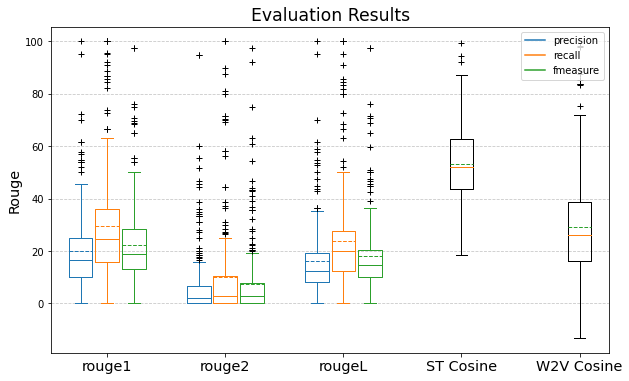

In [26]:
plot_evaluation_bullet_by_bullet(
    'google/pegasus-large')

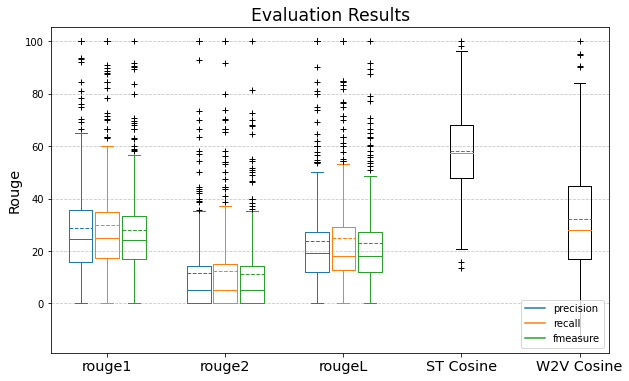

In [27]:
plot_evaluation_bullet_by_bullet(
    bucket_dir+'fine-tuning/ft_pegasus_para_wordembed_gas64_lr5e-05/checkpoint-686/')

#### Plot evaluation grouping bullets

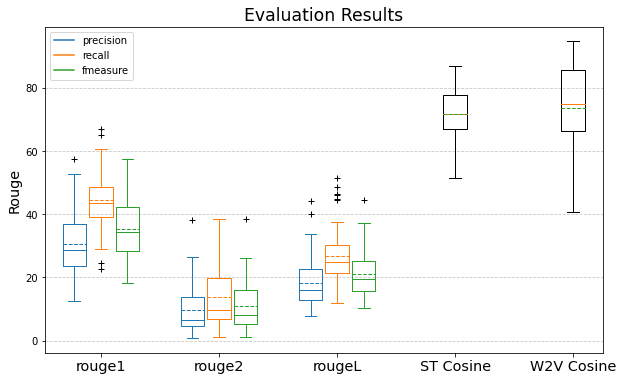

In [28]:
plot_evaluation_grouping_bullets(
    'google/pegasus-large')

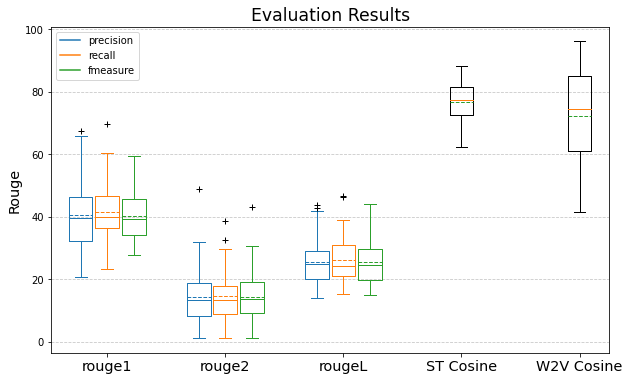

In [29]:
plot_evaluation_grouping_bullets(
    bucket_dir+'fine-tuning/ft_pegasus_para_wordembed_gas64_lr5e-05/checkpoint-686/')